For the the 2nd part of the assignment (forecasting) I have chosen a dataset of coffee shop revenue from Kaggle. The dataset contains sales numbers and prices of sold items data for half a year: from 2023-01-01 to 2023-06-30.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("agungpambudi/trends-product-coffee-shop-sales-revenue-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/akozlova/.cache/kagglehub/datasets/agungpambudi/trends-product-coffee-shop-sales-revenue-dataset/versions/3


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

In [3]:
df = pd.read_csv(f"{path}/coffee-shop-sales-revenue.csv", sep="|")
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [4]:
df.tail()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
149111,149452,2023-06-30,20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg
149112,149453,2023-06-30,20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg
149113,149454,2023-06-30,20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup


In [5]:
df.shape

(149116, 11)

In [6]:
df.transaction_date.describe()

count         149116
unique           181
top       2023-06-19
freq            1343
Name: transaction_date, dtype: object

In [7]:
# statistics summary of numerical values
df[["transaction_qty", "unit_price"]].describe()

,transaction_qty,unit_price
count,149116.000000,149116.000000
mean,1.438276,3.382219
std,0.542509,2.658723
min,1.000000,0.800000
25%,1.000000,2.500000
50%,1.000000,3.000000
75%,2.000000,3.750000
max,8.000000,45.000000


In [8]:
# combine date and time into one transaction_datetime column
df['transaction_datetime'] = pd.to_datetime(df['transaction_date'] + ' ' + df['transaction_time'])

# calculate revenue from each purchase
df['transaction_sum'] = df.transaction_qty * df.unit_price

<Axes: title={'center': 'Hourly revenue'}, xlabel='date_hour'>

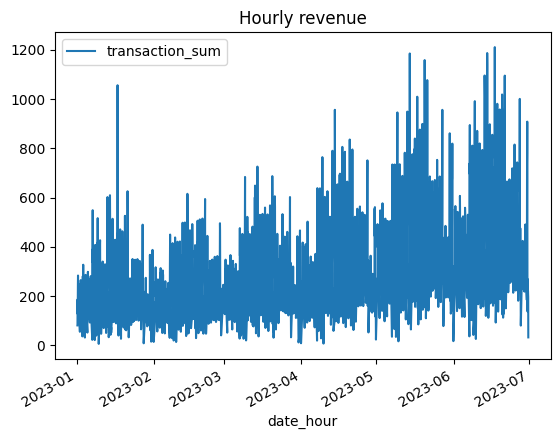

In [9]:
# to see the dynamics of revenue, we need to aggregate data (e.g. by hour)
df['date_hour'] = df['transaction_datetime'].dt.floor('h')
hourly_data = df.groupby('date_hour').agg({'transaction_sum': 'sum'})
hourly_data.plot(title="Hourly revenue")

<Axes: xlabel='date_hour'>

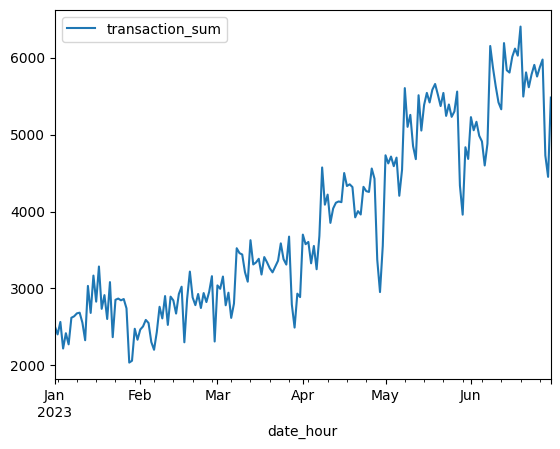

In [10]:
# aggregate the data by day, to get a more high-level picture
daily_data = pd.DataFrame(hourly_data.transaction_sum.resample('D').sum())
daily_data.plot()

<Axes: title={'center': 'Median revenue by day of week'}>

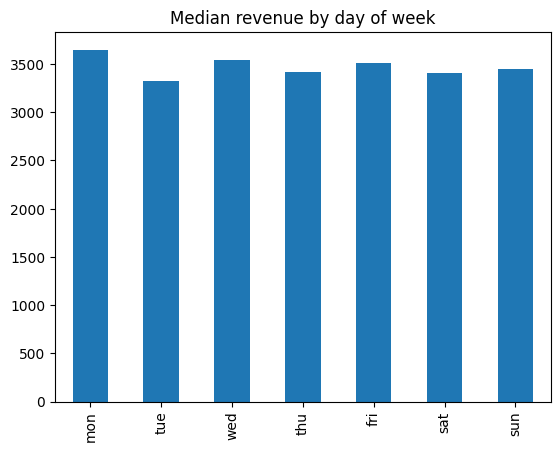

In [11]:
# revenue differ insignificantly depending on a day of week
weekdays = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
daily_data['weekday'] = daily_data.index.dayofweek
weekday_agg = daily_data.groupby('weekday').aggregate({"transaction_sum": "median"})
weekday_agg.index = weekdays
weekday_agg.plot(kind="bar", legend=False, title="Median revenue by day of week")

<Axes: xlabel='date_hour'>

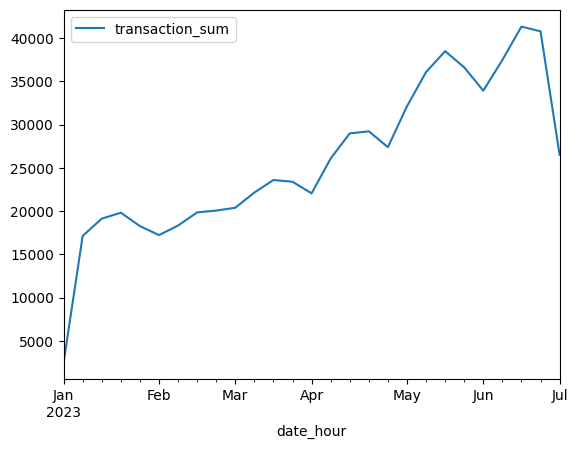

In [12]:
# aggregate the data by week
weekly_data = pd.DataFrame(hourly_data.transaction_sum.resample('W').sum())
weekly_data.plot()

<Axes: xlabel='date_hour'>

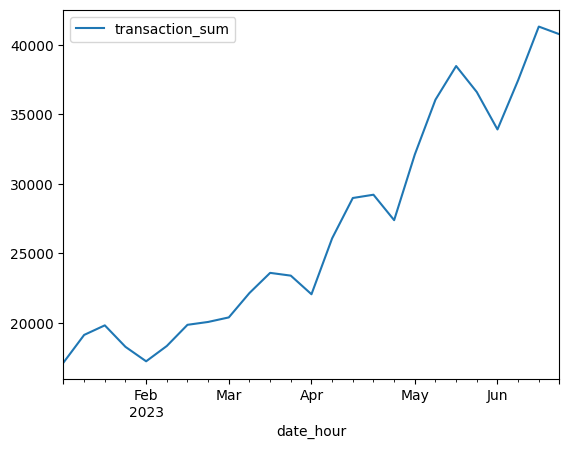

In [13]:
# the first and the last weeks are incompete and spoil the picture, let's remove them
weekly_data.iloc[1:-1].plot()

# Forecast Future Revenue: Exponential Smoothing

## Simple smoothing

Here I apply simple exponential smoothing to data to get basic forecast, based on the assumption that there's no trend or seasonality in the time series.

In [14]:
model1 = ExponentialSmoothing(daily_data['transaction_sum'], freq='D').fit()

<Axes: xlabel='date_hour'>

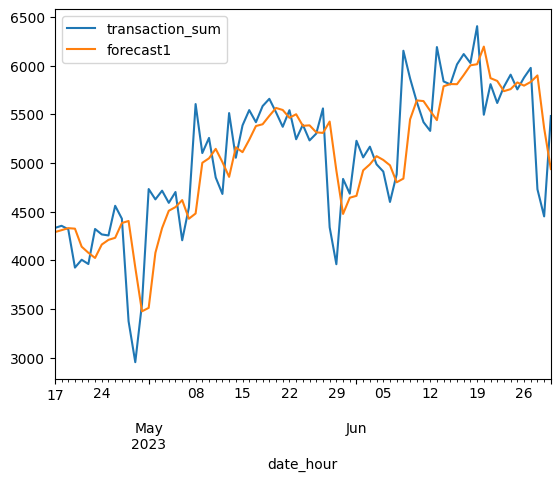

In [15]:
daily_data['forecast1'] = model1.fittedvalues
daily_data[["transaction_sum", "forecast1"]][-75:].plot()  # plot last 75 points

Text(0, 0.5, 'Prediction residuals')

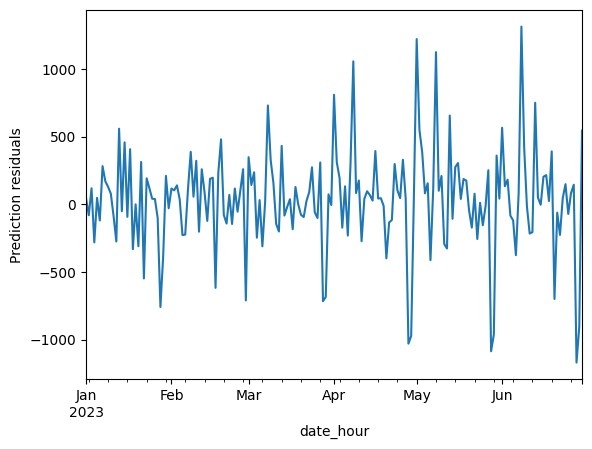

In [16]:
# model error
daily_data['residuals1'] = model1.resid
daily_data['residuals1'].plot()
plt.ylabel('Prediction residuals')

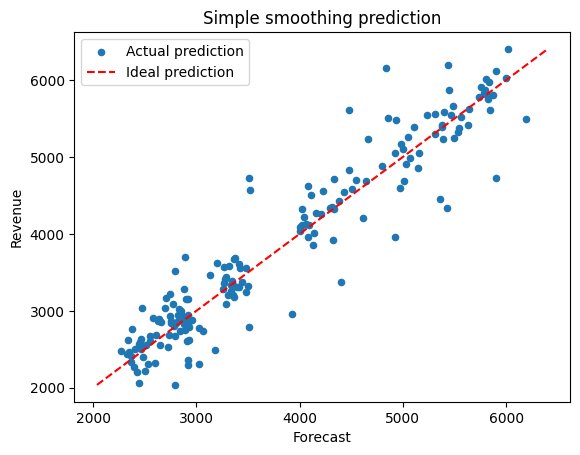

In [17]:
daily_data.plot(kind='scatter', x='forecast1', y='transaction_sum', label="Actual prediction")
max_val = max(daily_data.forecast1.max(), daily_data.transaction_sum.max())
min_val = min(daily_data.forecast1.min(), daily_data.transaction_sum.min())

# plot the line corresponding to "ideal" prediction
diagonal = np.linspace(min_val, max_val, 100)
plt.plot(diagonal, diagonal, 'r--', label='Ideal prediction')
plt.xlabel('Forecast')
plt.ylabel('Revenue')
plt.title("Simple smoothing prediction")
plt.legend()

In [18]:
model1.summary()

Dep. Variable:,transaction_sum,No. Observations:,181
Model:,ExponentialSmoothing,SSE,24910999.480
Optimized:,True,AIC,2145.650
Trend:,None,BIC,2152.047
Seasonal:,None,AICC,2145.878
Seasonal Periods:,None,Date:,"Fri, 04 Apr 2025"
Box-Cox:,False,Time:,21:31:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4631994,alpha,True
initial_level,2463.7945,l.0,True


## Predictions

Trying to forecast yet unseen values.

<Axes: xlabel='date_hour'>

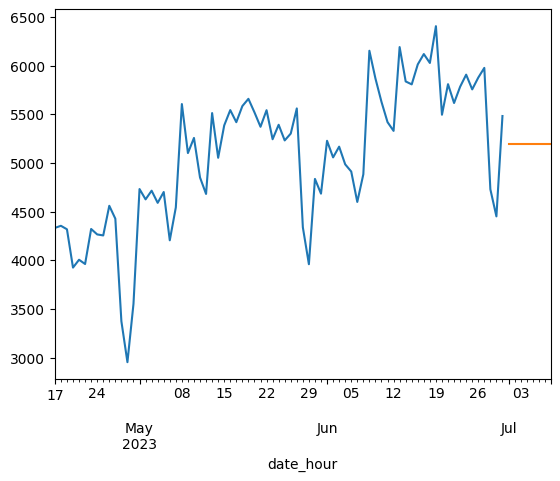

In [19]:
# simple exponential smoothing produces a constant forecast (straight line)
forecasts = model1.forecast(8)
daily_data[-75:].transaction_sum.plot()
forecasts.plot()

## Double Exponential Smoothing

Double exponential smoothing takes into account the trend in the data.

In [20]:
model2 = ExponentialSmoothing(daily_data.transaction_sum, trend='add', freq='D').fit()

<Axes: xlabel='date_hour'>

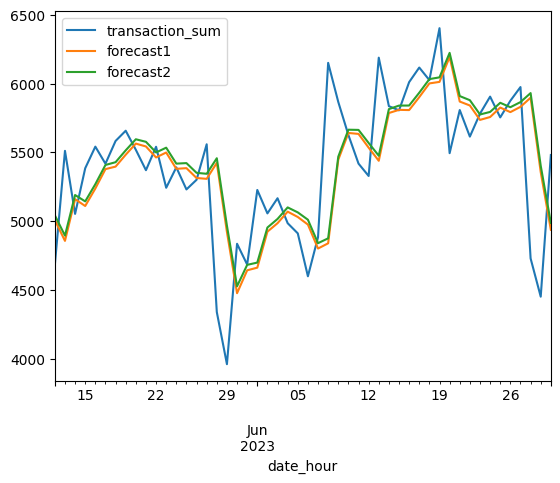

In [21]:
# compare forecast1 (simple smoothing) with forecast2 (double smoothing
daily_data['forecast2'] = model2.fittedvalues
daily_data[-50:].drop(['residuals1', 'weekday'], axis=1).plot()

<Axes: title={'center': 'Prediction residuals'}, xlabel='date_hour', ylabel='residuals'>

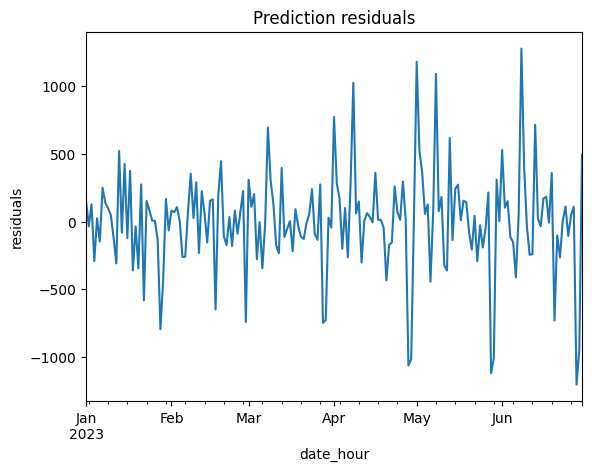

In [22]:
daily_data['residuals2'] = model2.resid
daily_data['residuals2'].plot(ylabel="residuals", title="Prediction residuals")

Text(0.5, 1.0, 'Double smoothing prediction')

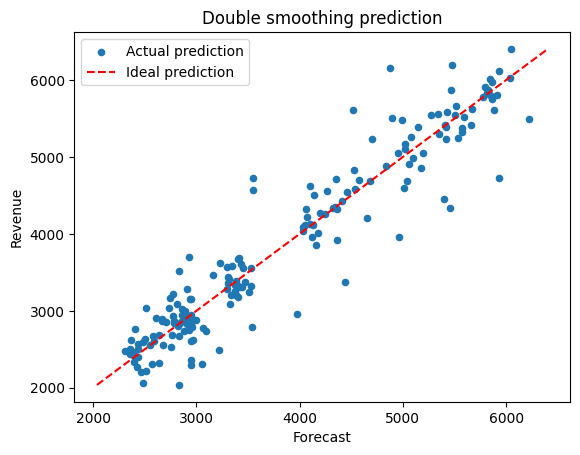

In [23]:
daily_data.plot(kind='scatter', x='forecast2', y='transaction_sum', label="Actual prediction")
max_val = max(daily_data.forecast1.max(), daily_data.transaction_sum.max())
min_val = min(daily_data.forecast1.min(), daily_data.transaction_sum.min())

# plot the line corresponding to "ideal" prediction
diagonal = np.linspace(min_val, max_val, 100)
plt.plot(diagonal, diagonal, 'r--', label='Ideal prediction')
plt.xlabel('Forecast')
plt.ylabel('Revenue')
plt.legend()
plt.title("Double smoothing prediction")

In [24]:
model2.summary()

Dep. Variable:,transaction_sum,No. Observations:,181
Model:,ExponentialSmoothing,SSE,24730274.417
Optimized:,True,AIC,2148.333
Trend:,Additive,BIC,2161.127
Seasonal:,None,AICC,2148.815
Seasonal Periods:,None,Date:,"Fri, 04 Apr 2025"
Box-Cox:,False,Time:,21:31:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4527665,alpha,True
smoothing_trend,0.0003993,beta,True


<Axes: xlabel='date_hour'>

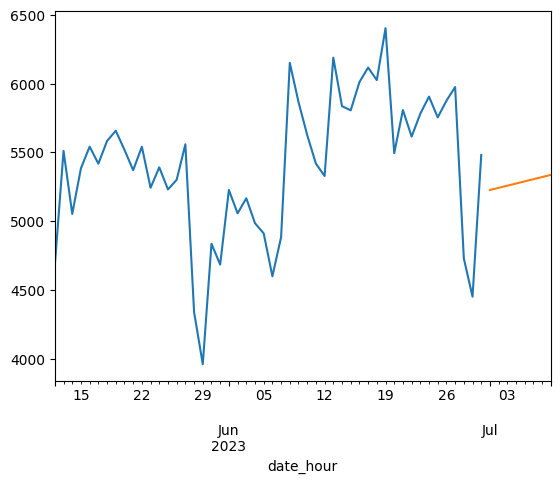

In [25]:
# prediction of unseen values
forecasts2 = model2.forecast(8)
daily_data[-50:].transaction_sum.plot()
forecasts2.plot()

## Triple exponential smoothing

Triple exponential smoothing aims to forecast time series values taking into account both trend and seasonality.

Decomposing time series shows data variation on different levels. Some variation is justified by trend and seasonality. Other variation is not - then it is residuals.

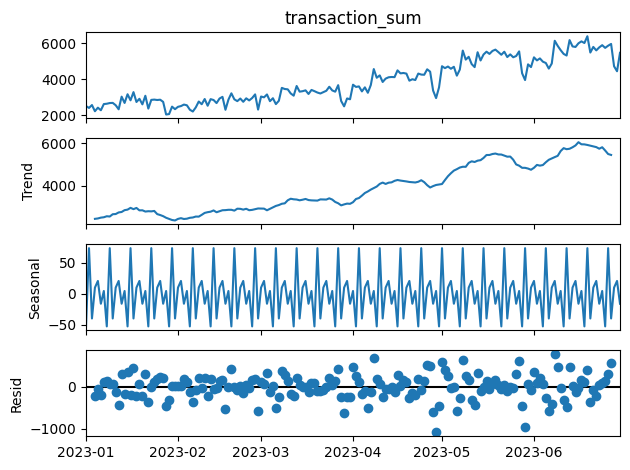

In [26]:
decompose = seasonal_decompose(daily_data.transaction_sum).plot()

To perform triple smoothing, we should define the parameter `seasonal_periods`. It is a number of data points that form some seasonal cycle. I assume that there is a weekly cycle (`seasonal_periods=7`) and a monthly cycle (`seasonal_periods=30`) in the data. Let's compare models with both seasonal_periods values.

In [27]:
model3 = ExponentialSmoothing(daily_data.transaction_sum, trend='add', seasonal='mul',
                             seasonal_periods=30, freq='D').fit()
daily_data['forecast3'] = model3.fittedvalues

<Axes: xlabel='date_hour'>

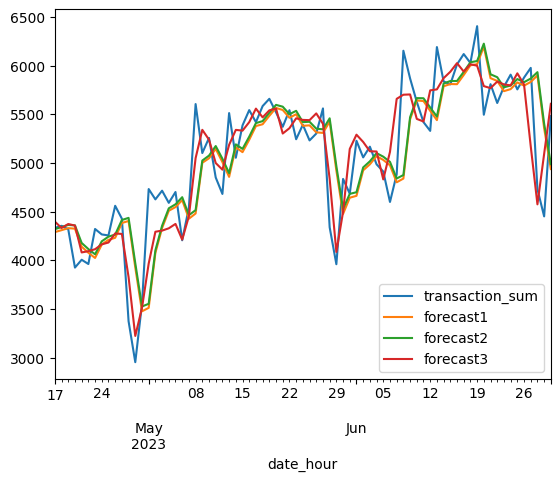

In [28]:
# Compare forecasts from 3 models. Forecast 3 is for triple smoothing with seasonal_periods=30.
daily_data[-75:].drop(['residuals1', 'residuals2', 'weekday'], axis=1).plot()

In [29]:
model4 = ExponentialSmoothing(daily_data.transaction_sum, trend='add', seasonal='mul',
                             seasonal_periods=7, freq='D').fit()

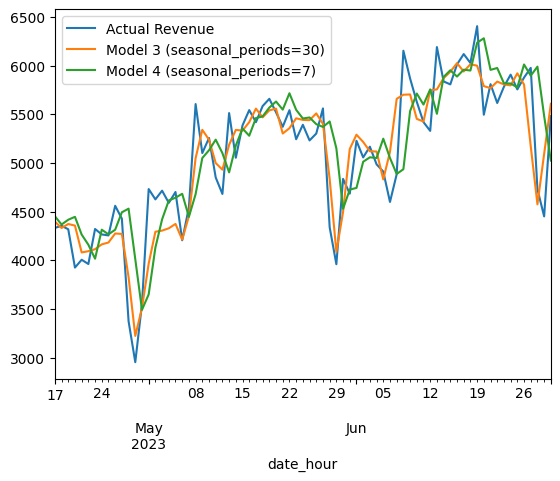

In [30]:
# Now compare forecasts from models 3 and 4: triple smoothing with monthly and weekly seasonality.
daily_data['forecast4'] = model4.fittedvalues
ax = daily_data[-75:][['transaction_sum', 'forecast3', 'forecast4']].plot()
ax.legend(['Actual Revenue', 'Model 3 (seasonal_periods=30)', 'Model 4 (seasonal_periods=7)'])

Visually it seems that model3 performs better than model4. Let's compare quality metrics.

In [31]:
# calculate error metrics for both models
metrics_model3 = {
   'model': 'Model 3',
   'mae': mean_absolute_error(daily_data.transaction_sum, daily_data.forecast3),
   'rmse': np.sqrt(mean_squared_error(daily_data.transaction_sum, daily_data.forecast3)),
   'mape': np.mean(np.abs((daily_data.transaction_sum - daily_data.forecast3) / daily_data.transaction_sum)) * 100,
   'r2': r2_score(daily_data.transaction_sum, daily_data.forecast3)
}

metrics_model4 = {
   'model': 'Model 4',
   'mae': mean_absolute_error(daily_data.transaction_sum, daily_data.forecast4),
   'rmse': np.sqrt(mean_squared_error(daily_data.transaction_sum, daily_data.forecast4)),
   'mape': np.mean(np.abs((daily_data.transaction_sum - daily_data.forecast4) / daily_data.transaction_sum)) * 100,
   'r2': r2_score(daily_data.transaction_sum, daily_data.forecast4)
}
metrics_df = pd.DataFrame([metrics_model3, metrics_model4])
print(metrics_df)

     model         mae        rmse      mape        r2
0  Model 3  206.136012  270.154712  5.777557  0.947985
1  Model 4  258.073200  378.768336  7.281578  0.897753


Based on these metrics, Model 3 is clearly outperforming Model 4, which means it gives more accurate predictions.

<Axes: xlabel='date_hour'>

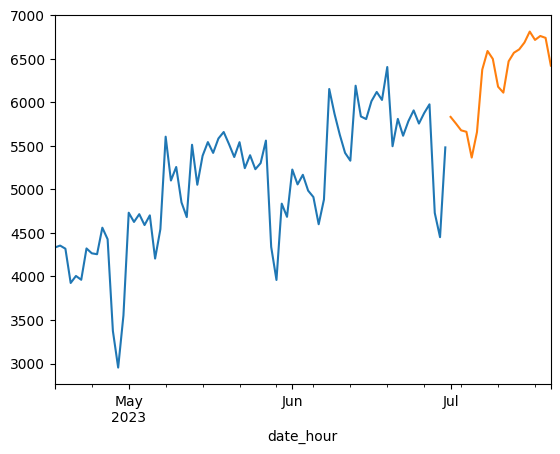

In [32]:
# predictions of unseen values
forecasts3 = model3.forecast(20)
daily_data[-75:].transaction_sum.plot()
forecasts3.plot()